In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from moviepy.editor import VideoFileClip
%matplotlib inline

### Camera Calibration and Distortion Correction

#### already done in the file 'for test images.ipynb'

### Image distortion correction and perspective transform

In [2]:
def warp(img):
    dist_pickle = pickle.load(open("camera_cal/dist_picklecol.p", 'rb' ))
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    h,w = img.shape[:2]
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    src=np.float32([[580,460],[700,460],[1096,720],[200,720]])
    dst=np.float32([[250,0],[w-320,0],[w-320,h],[250,h]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undist_img, M, (w,h), flags=cv2.INTER_LINEAR)
    return undist_img, warped, Minv

### Filter (Gradient, Magnitude, Color)

In [3]:
# filter magnitude and gradient related
def filter_sobelx(img, thresh=(45,230), sobel_kernel=3):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    mask_grad = np.zeros_like(scaled_sobelx)
    mask_grad[(scaled_sobelx >= thresh[0]) & (scaled_sobelx <= thresh[1])]=1
    return mask_grad

def filter_mag(img, sobel_kernel=3, mag_thresh=(30, 150)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)        
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_mag = np.max(gradmag)/255 
    gradmag = (gradmag/scale_mag).astype(np.uint8)
    mask_mag = np.zeros_like(gradmag)
    mask_mag[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mask_mag

def filter_dir(img, sobel_kernel=3, thresh=(0.7, 1.3)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    mask_dir =  np.zeros_like(absgraddir)
    mask_dir[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return mask_dir
    
# filter color related
def color_wy(imgs, n, thresh=(0, 255)):
    imgs_lab = cv2.cvtColor(imgs, cv2.COLOR_RGB2LAB)
    channel = imgs_lab[:,:,n]
    out = np.zeros_like(channel)
    out[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return out

def filter_hls(img_color,thresh=(190,255)):
    hls = cv2.cvtColor(img_color, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,2]
    mask_l = np.zeros_like(l_channel)
    mask_l[(l_channel >= thresh[0]) & (l_channel <= thresh[1])]=1
    return mask_l

def filter_hls1(img_color,thresh=(220,255)):
    hls = cv2.cvtColor(img_color, cv2.COLOR_RGB2HLS)
    l1_channel = hls[:,:,1]
    mask_l1 = np.zeros_like(l1_channel)
    mask_l1[(l1_channel >= thresh[0]) & (l1_channel <= thresh[1])]=1
    return mask_l1

### Lane Detecion, Curve Radius and Car Position

In [4]:
# Slide windows and parameters output
def hist(img_hist):
    # sliding windows
    bottom_half = img_hist[img_hist.shape[0]//2:, :]
    histogram = np.sum(bottom_half, axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows=10
    margin = 80
    minpix=50
    window_height = np.int(img_hist.shape[0]//nwindows)
    nonzero = img_hist.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    for window in range(nwindows):
        win_low = img_hist.shape[0]-(window+1)*window_height
        win_high = img_hist.shape[0]-window*window_height
        win_left_low = leftx_current - margin
        win_left_high = leftx_current + margin
        win_right_low = rightx_current - margin
        win_right_high = rightx_current + margin
        good_left_inds = ((nonzeroy >= win_low) & (nonzeroy < win_high) & 
        (nonzerox >= win_left_low) & (nonzerox < win_left_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_low) & (nonzeroy < win_high) & 
        (nonzerox >= win_right_low) &  (nonzerox < win_right_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # fit lanes with polynomials
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0,img_hist.shape[0],img_hist.shape[0]+1)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # calculate the radius of curvature of the left/right lanes
    left_curverad=0
    right_curverad=0
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*xm_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # calculate the position od the vehicle with respect to center
    car_pos = img_hist.shape[1]/2
    center_lane_pos = (leftx_base + rightx_base)/2
    dist_car= (car_pos-center_lane_pos)*xm_per_pix
    
    #save results
    poly_result = {}
    poly_result['left_fit'] = left_fit
    poly_result['right_fit'] = right_fit
    poly_result['left_fitx'] =left_fitx
    poly_result['right_fitx'] =right_fitx
    poly_result['ploty'] = ploty
    poly_result['left_curverad'] = left_curverad
    poly_result['right_curverad'] = right_curverad
    poly_result['dist_car'] = dist_car
    
    return poly_result

### video loading and processing

In [5]:
def process_image(img_from_video):
    
    undist_img, transform_undst_img, Minv = warp(img_from_video)
    
    # LAB filter parameters
    yellow_l = color_wy(transform_undst_img, 0, thresh=(170, 255))
    yellow_a = color_wy(transform_undst_img, 1, thresh=(100, 250))
    yellow_b = color_wy(transform_undst_img, 2, thresh=(150, 255))
    yellow = np.zeros_like(yellow_l)
    yellow[(yellow_l == 1) & (yellow_a == 1) &(yellow_b == 1)] = 1
    
    white_l = color_wy(transform_undst_img, 0, thresh=(210, 255))
    white_a = color_wy(transform_undst_img, 1, thresh=(100, 150))
    white_b = color_wy(transform_undst_img, 2, thresh=(100, 150))
    white = np.zeros_like(white_l)
    white[(white_l == 1) & (white_a == 1) & (white_b == 1)] = 1
    
    # other filter parameters
    tui_after_x = filter_sobelx(transform_undst_img)
    tui_after_mag= filter_mag(transform_undst_img)
    tui_after_dir= filter_dir(transform_undst_img)
    tui_after_hls= filter_hls(transform_undst_img)
    tui_after_hls1= filter_hls1(transform_undst_img)
    
    # combine filters
    input_lane = transform_undst_img[:,:,2]
    combinedall = np.zeros_like(input_lane)
    #combinedall[(yellow == 1) | (white == 1)] = 1
    #combinedall[((tui_after_hls1 == 1)&(tui_after_x == 1))| (yellow == 1) | (white == 1)|
                #(tui_after_mag == 1)& (tui_after_dir ==1)] = 1
    combinedall[(tui_after_x == 1)| (yellow == 1) | (white == 1)
                |(tui_after_mag == 1)& (tui_after_dir ==1)
                |((tui_after_hls1==1)&(tui_after_hls==1))] = 1
    output_lane = combinedall
    
    parameter_hist=hist(output_lane)
    
    # print result 
    ploty = parameter_hist['ploty']
    left_fitx = parameter_hist['left_fitx']
    right_fitx = parameter_hist['right_fitx']
    left_curverad = parameter_hist['left_curverad']
    right_curverad = parameter_hist['right_curverad'] 
    dist_car= parameter_hist['dist_car']
    color_blankboard = np.zeros((720,1280,3), np.uint8)
    draw_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    draw_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    draw_line = np.hstack((draw_left, draw_right))
    draw_line = draw_line.astype(np.int)
    cv2.fillPoly(color_blankboard, draw_line, (0,255, 20))
    newwarp = cv2.warpPerspective(color_blankboard, Minv, (1280,720))
    integrate_photo= cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    cv2.putText(integrate_photo,"Left curvature: %.1f m." % left_curverad,(50, 70), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
    cv2.putText(integrate_photo,"Right curvature: %.1f m." % right_curverad,(50, 120), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
    cv2.putText(integrate_photo,"right(+), left(-): %.1f m." % dist_car,(50, 170), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
    plt.imshow(integrate_photo)
    return integrate_photo

[MoviePy] >>>> Building video project_video_result_final.mp4
[MoviePy] Writing video project_video_result_final.mp4


100%|█████████▉| 1260/1261 [10:50<00:00,  1.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result_final.mp4 

CPU times: user 6min 57s, sys: 1min 34s, total: 8min 31s
Wall time: 10min 53s


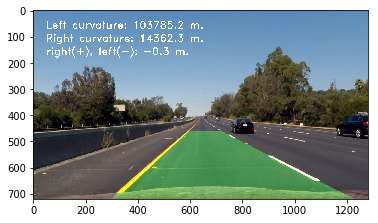

In [6]:
white_output = 'project_video_result_final.mp4'
clip = VideoFileClip("project_video.mp4")
white_clip = clip.fl_image(process_image) 
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video project_video_challenge_final.mp4
[MoviePy] Writing video project_video_challenge_final.mp4


100%|██████████| 485/485 [04:06<00:00,  1.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_challenge_final.mp4 

CPU times: user 2min 38s, sys: 36.6 s, total: 3min 14s
Wall time: 4min 9s


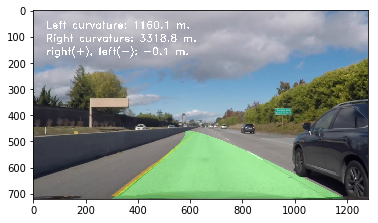

In [7]:
white_output = 'project_video_challenge_final.mp4'
clip = VideoFileClip("challenge_video.mp4")
white_clip = clip.fl_image(process_image) 
%time white_clip.write_videofile(white_output, audio=False)
